In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statistics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.inspection import permutation_importance
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import matthews_corrcoef
import shap
import statsmodels.api as sm
from sklearn.feature_selection import chi2, f_classif
from sklearn.calibration import calibration_curve
from scipy.stats import wilcoxon
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import statsmodels.stats.multitest as multitest

In [2]:
jadni_data = pd.read_csv('JADNI_final_04_09_2020.csv')
#jadni_data = pd.read_csv('JADNI_split_24_8_2020.csv')
jadni_data = jadni_data.drop(["RACE"], axis = 1)
len(jadni_data)

234

In [3]:
jadni_data = jadni_data.dropna()
jadni_data = jadni_data[jadni_data.DXCURREN != "CN"]

len(jadni_data)

234

## Splitting

In [4]:
#le_race = LabelEncoder()
le_gender = LabelEncoder()
le_ethnicity = LabelEncoder()
le_marry = LabelEncoder()

#jadni_data['RACE'] = le_race.fit_transform(jadni_data['RACE'])
jadni_data['Gender'] = le_gender.fit_transform(jadni_data['Gender'])
jadni_data['Marry'] = le_marry.fit_transform(jadni_data['Marry'])
jadni_data.head()

,X1,DXCURREN,VISCODE,FAQ_FINAN,FAQ_FORM,FAQ_SHOP,FAQ_GAME,FAQ_BEVG,FAQ_MEAL,FAQ_EVENT,FAQ_TV,FAQ_REM,FAQ_TRAVL,PTEDUCAT,Gender,Marry,long.age
0,JADNI0005,MCI,0,4,5,4,4,4,4,4,4,3,4,11,0,1,80.0
1,JADNI0025,MCI,0,1,1,0,0,0,1,3,0,0,3,12,1,1,78.0
2,JADNI0040,MCI,12,4,4,0,3,0,0,4,0,4,4,12,0,3,76.0
3,JADNI0045,MCI,0,3,2,0,0,0,3,3,0,3,3,16,0,1,63.0
4,JADNI0065,MCI,0,3,0,0,0,0,0,4,0,4,0,11,0,1,77.0


In [5]:
x_faq = jadni_data.filter(items = ["FAQ_FINAN","FAQ_FORM","FAQ_SHOP",
                                        "FAQ_GAME","FAQ_BEVG","FAQ_MEAL","FAQ_EVENT","FAQ_TV","FAQ_REM"
                         ,"FAQ_TRAVL"]).values
x_total = jadni_data.filter(items = ["FAQ_FINAN","FAQ_FORM","FAQ_SHOP",
                                        "FAQ_GAME","FAQ_BEVG","FAQ_MEAL","FAQ_EVENT","FAQ_TV","FAQ_REM"
                         ,"FAQ_TRAVL","PTEDUCAT","Gender","Marry","long.age"]).values
y = jadni_data.filter(items = ["DXCURREN"]).values

In [6]:
jadni_le = LabelEncoder()
y = jadni_le.fit_transform(y)

/Users/maborageh/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Random Forest

In [7]:
RF = RandomForestClassifier(random_state = 1)

In [8]:
p_grid = {"n_estimators" : [100,300,500,800],
         "min_samples_split" : [2,5,10,15],
         "min_samples_leaf" : [1, 2, 5, 10]}

In [9]:
clf = GridSearchCV(estimator = RF, param_grid = p_grid, cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
clf_fit = clf.fit(x_faq,y).predict_proba(x_faq)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  1.5min finished


In [10]:
feature_importances = permutation_importance(clf, x_faq, y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [11]:
feature_names_faq = ["FAQ_FINAN","FAQ_FORM","FAQ_SHOP",
                                        "FAQ_GAME","FAQ_BEVG","FAQ_MEAL","FAQ_EVENT","FAQ_TV","FAQ_REM"
                         ,"FAQ_TRAVL"]
indices = np.argsort(feature_importances.importances_mean)[::-1]
scores = []
ticks = []
for i in indices:
    scores.append(feature_importances.importances_mean[i])
    ticks.append(feature_names_faq[i])
    print("{}: {:.3f}".format(feature_names_faq[i], feature_importances.importances_mean[i]))

FAQ_FORM: 0.070
FAQ_GAME: 0.063
FAQ_SHOP: 0.053
FAQ_MEAL: 0.053
FAQ_FINAN: 0.052
FAQ_REM: 0.052
FAQ_EVENT: 0.049
FAQ_TRAVL: 0.048
FAQ_TV: 0.033
FAQ_BEVG: 0.024


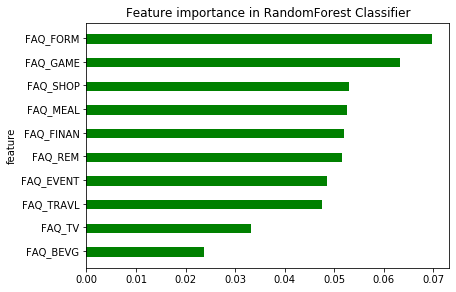

<Figure size 360x360 with 0 Axes>

In [12]:
fig, ax = plt.subplots() 
width = 0.4
ind = np.arange(len(scores))
ax.barh(ind, scores[::-1], width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(ticks[::-1], minor=False)
plt.title("Feature importance in RandomForest Classifier")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

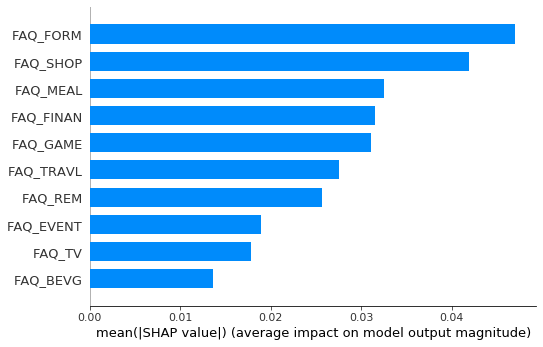

In [13]:
shap_values = shap.TreeExplainer(clf.best_estimator_).shap_values(x_faq)
shap.summary_plot(shap_values[0], x_faq,feature_names = feature_names_faq,plot_type = "bar")

## Gradient Boosting

In [14]:
GB = GradientBoostingClassifier(random_state = 1)

In [15]:
gb_grid = {"n_estimators" : [100,300,500,800],
         "min_samples_split" : [2,5,10,15],
         "min_samples_leaf" : [1,2,5,10],
          "learning_rate": [0.01,0.05,0.1]}

In [16]:
gbf = GridSearchCV(estimator = GB, param_grid = gb_grid, cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
gbf_fit = gbf.fit(x_faq,y)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 838 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1838 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  1.8min finished


In [17]:
gb_feature_importances = permutation_importance(gbf_fit, x_faq, y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [18]:
feature_names_faq = ["FAQ_FINAN","FAQ_FORM","FAQ_SHOP",
                                        "FAQ_GAME","FAQ_BEVG","FAQ_MEAL","FAQ_EVENT","FAQ_TV","FAQ_REM"
                         ,"FAQ_TRAVL"]
gb_indices = np.argsort(gb_feature_importances.importances_mean)[::-1]
scores = []
ticks = []
for i in gb_indices:
    scores.append(gb_feature_importances.importances_mean[i])
    ticks.append(feature_names_faq[i])
    print("{}: {:.3f}".format(feature_names_faq[i], gb_feature_importances.importances_mean[i]))

FAQ_GAME: 0.130
FAQ_SHOP: 0.100
FAQ_MEAL: 0.063
FAQ_BEVG: 0.047
FAQ_FINAN: 0.039
FAQ_TV: 0.033
FAQ_REM: 0.031
FAQ_FORM: 0.031
FAQ_TRAVL: 0.028
FAQ_EVENT: 0.020


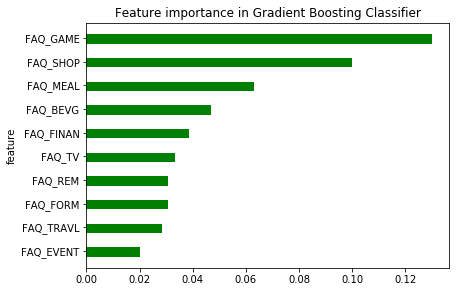

<Figure size 360x360 with 0 Axes>

In [19]:
fig, ax = plt.subplots() 
width = 0.4
ind = np.arange(len(scores))
ax.barh(ind, scores[::-1], width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(ticks[::-1], minor=False)
plt.title("Feature importance in Gradient Boosting Classifier")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

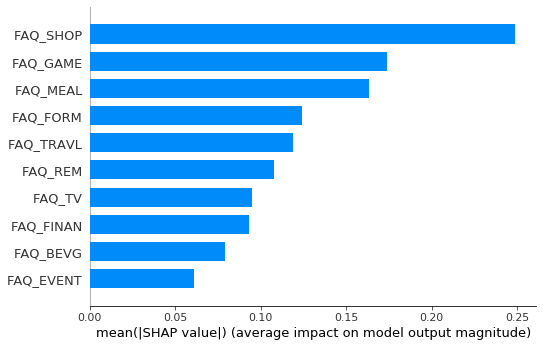

In [20]:
gb_shap_values = shap.TreeExplainer(gbf.best_estimator_).shap_values(x_faq)
shap.summary_plot(gb_shap_values, x_faq,feature_names = feature_names_faq,plot_type = "bar")

## Logistic Regression

In [21]:
LR = LogisticRegression()

In [22]:
lr_grid = {"penalty":["l1","l2"],
          "C":np.logspace(-4,4,20),
          "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          "max_iter":[100,1000,2500,5000]}

In [23]:
lrf = GridSearchCV(estimator = LR, param_grid = lr_grid, cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
lrf_fit = lrf.fit(x_faq,y)

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:    5.5s finished


In [24]:
lr_feature_importances = permutation_importance(lrf_fit, x_faq, y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [25]:
feature_names_faq = ["FAQ_FINAN","FAQ_FORM","FAQ_SHOP",
                                        "FAQ_GAME","FAQ_BEVG","FAQ_MEAL","FAQ_EVENT","FAQ_TV","FAQ_REM"
                         ,"FAQ_TRAVL"]
lr_indices = np.argsort(lr_feature_importances.importances_mean)[::-1]
scores = []
ticks = []
for i in gb_indices:
    scores.append(lr_feature_importances.importances_mean[i])
    ticks.append(feature_names_faq[i])
    print("{}: {:.3f}".format(feature_names_faq[i], lr_feature_importances.importances_mean[i]))

FAQ_GAME: 0.009
FAQ_SHOP: 0.022
FAQ_MEAL: 0.012
FAQ_BEVG: 0.000
FAQ_FINAN: 0.003
FAQ_TV: 0.003
FAQ_REM: 0.009
FAQ_FORM: 0.016
FAQ_TRAVL: 0.002
FAQ_EVENT: 0.003


## Nested Cross Validation

In [78]:
outer_cv = 10

#Metrics to calculate

specificity = make_scorer(recall_score, pos_label=0)
sensitivity = make_scorer(recall_score, pos_label=1)
mcc = make_scorer(matthews_corrcoef)

s_dict = {"specificity" : make_scorer(recall_score, pos_label=0),
         "sensitivity" : make_scorer(recall_score, pos_label=1),
         "mcc":make_scorer(matthews_corrcoef)}

scores = {'accuracy' : 'accuracy',
         'precision' : 'precision',
          "roc":'roc_auc',
          "balanced_acc":"balanced_accuracy",
         "specificity" : s_dict["specificity"],
         "sensitivity" : s_dict["sensitivity"],
         "MCC":s_dict["mcc"],
         "f1_score":"f1"}

In [27]:
rf_class_probabilities = cross_val_predict(estimator = clf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 12.5min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 20.3min finished


In [28]:
gb_class_probabilities = cross_val_predict(estimator = gbf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 17.8min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 31.0min finished


In [29]:
lr_class_probabilities = cross_val_predict(estimator = lrf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   46.0s remaining:   30.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


In [30]:
rf_proba = rf_class_probabilities[:,1]

rf_fraction_of_positives, rf_mean_predicted_value = calibration_curve(y, rf_proba, n_bins=10)

In [31]:
gb_proba = gb_class_probabilities[:,1]

gb_fraction_of_positives, gb_mean_predicted_value = calibration_curve(y, gb_proba, n_bins=10)

In [32]:
lr_proba = lr_class_probabilities[:,1]

lr_fraction_of_positives, lr_mean_predicted_value = calibration_curve(y, lr_proba, n_bins=10)

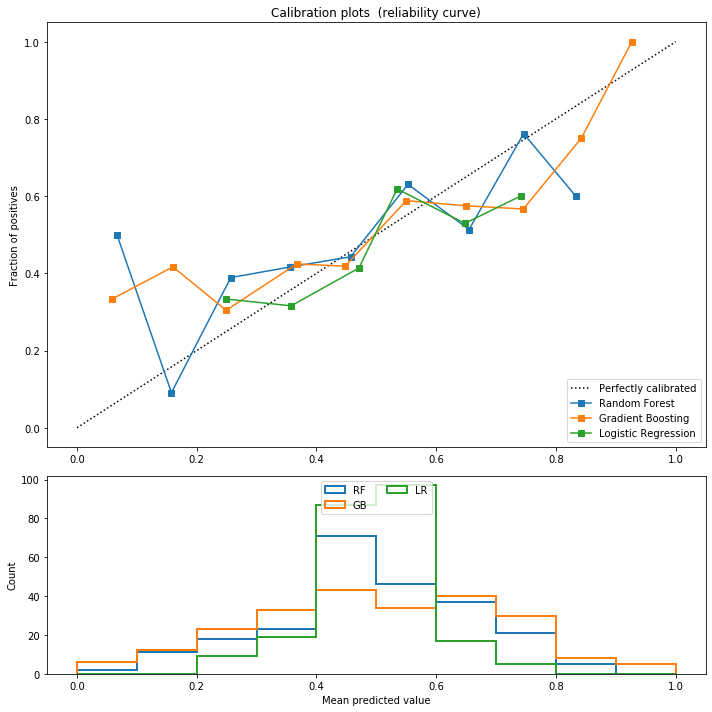

In [33]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(rf_mean_predicted_value, rf_fraction_of_positives, "s-",
             label="%s" % ("Random Forest", ))
ax1.plot(gb_mean_predicted_value, gb_fraction_of_positives, "s-",
             label="%s" % ("Gradient Boosting", ))
ax1.plot(lr_mean_predicted_value, lr_fraction_of_positives, "s-",
             label="%s" % ("Logistic Regression", ))


ax2.hist(rf_proba, range=(0, 1), bins=10, label="RF",
             histtype="step", lw=2)
ax2.hist(gb_proba, range=(0, 1), bins=10, label="GB",
             histtype="step", lw=2)
ax2.hist(lr_proba, range=(0, 1), bins=10, label="LR",
             histtype="step", lw=2)
    
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [34]:
rf_nested_scores = cross_validate(estimator = clf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 12.4min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 20.1min finished


In [35]:
gb_nested_scores = cross_validate(estimator = gbf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 17.7min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 30.8min finished


In [36]:
lr_nested_scores = cross_validate(estimator = lrf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   46.7s remaining:   31.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


In [37]:
print("Accuracy:", statistics.mean(rf_nested_scores['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(rf_nested_scores['test_balanced_acc']))
print("Precision:", statistics.mean(rf_nested_scores['test_precision']))
print("Specificity:", statistics.mean(rf_nested_scores['test_specificity']))
print("Sensitivity:", statistics.mean(rf_nested_scores['test_sensitivity']))
print("Matthews Correlation Coefficient:", statistics.mean(rf_nested_scores['test_MCC']))
print("F1 Score:", statistics.mean(rf_nested_scores['test_f1_score']))
print("ROC:", statistics.mean(rf_nested_scores['test_roc']))

Accuracy: 0.6059782608695652
Balanced Accuracy: 0.6060606060606061
Precision: 0.6229304029304029
Specificity: 0.6386363636363637
Sensitivity: 0.5734848484848485
Matthews Correlation Coefficient: 0.217675644816659
F1 Score: 0.5890026990553306
ROC: 0.6298295454545455


In [38]:
print("Accuracy:", statistics.mean(gb_nested_scores['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(gb_nested_scores['test_balanced_acc']))
print("Precision:", statistics.mean(gb_nested_scores['test_precision']))
print("Sensitivity:", statistics.mean(gb_nested_scores['test_sensitivity']))
print("Specificity:", statistics.mean(gb_nested_scores['test_specificity']))
print("Matthews Correlation Coefficient:", statistics.mean(gb_nested_scores['test_MCC']))
print("F1 Score:", statistics.mean(gb_nested_scores['test_f1_score']))
print("ROC", statistics.mean(gb_nested_scores['test_roc']))

Accuracy: 0.6063405797101449
Balanced Accuracy: 0.6060606060606061
Precision: 0.6071266233766234
Sensitivity: 0.6060606060606061
Specificity: 0.6060606060606061
Matthews Correlation Coefficient: 0.2166642478488535
F1 Score: 0.5995042844264812
ROC 0.6442234848484848


In [39]:
print("Accuracy:", statistics.mean(lr_nested_scores['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(lr_nested_scores['test_balanced_acc']))
print("Precision:", statistics.mean(lr_nested_scores['test_precision']))
print("Sensitivity:", statistics.mean(lr_nested_scores['test_sensitivity']))
print("Specificity:", statistics.mean(lr_nested_scores['test_specificity']))
print("Matthews Correlation Coefficient:", statistics.mean(lr_nested_scores['test_MCC']))
print("F1 Score:", statistics.mean(lr_nested_scores['test_f1_score']))
print("ROC", statistics.mean(lr_nested_scores['test_roc']))

Accuracy: 0.6068840579710145
Balanced Accuracy: 0.606439393939394
Precision: 0.6234535725712196
Sensitivity: 0.6151515151515151
Specificity: 0.5977272727272728
Matthews Correlation Coefficient: 0.22265360543642504
F1 Score: 0.6070784687021569
ROC 0.6425820707070707


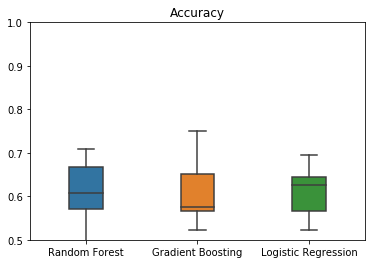

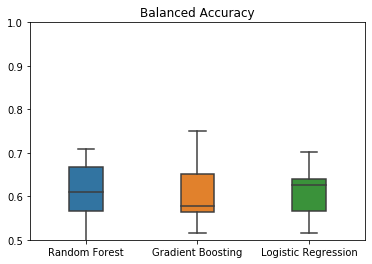

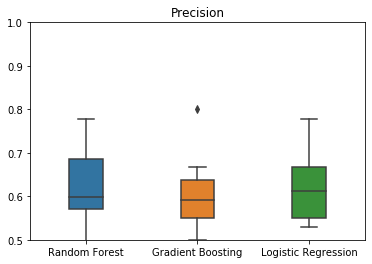

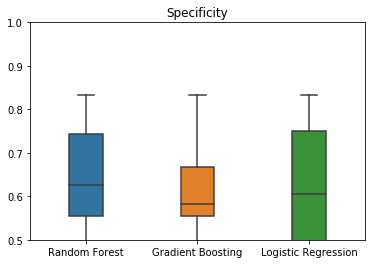

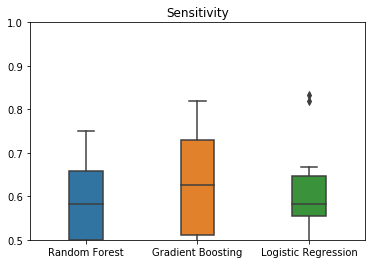

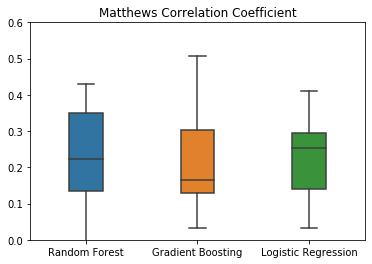

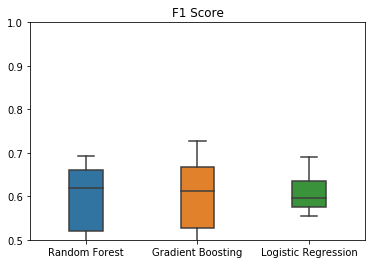

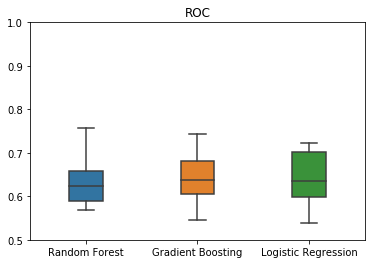

In [40]:
rf_acc = rf_nested_scores['test_accuracy']
gb_acc = gb_nested_scores['test_accuracy']
lr_acc = lr_nested_scores['test_accuracy']
sns.boxplot(data = [rf_acc,gb_acc,lr_acc], width = 0.3).set_title("Accuracy")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_ba_acc = rf_nested_scores['test_balanced_acc']
gb_ba_acc = gb_nested_scores['test_balanced_acc']
lr_ba_acc = lr_nested_scores['test_balanced_acc']
sns.boxplot(data = [rf_ba_acc,gb_ba_acc,lr_ba_acc], width = 0.3).set_title("Balanced Accuracy")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_precision = rf_nested_scores['test_precision']
gb_precision = gb_nested_scores['test_precision']
lr_precision = lr_nested_scores['test_precision']
sns.boxplot(data = [rf_precision,gb_precision,lr_precision], width = 0.3).set_title("Precision")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_spec = rf_nested_scores['test_specificity']
gb_spec = gb_nested_scores['test_specificity']
lr_spec = lr_nested_scores['test_specificity']
sns.boxplot(data = [rf_spec,gb_spec,lr_spec], width = 0.3).set_title("Specificity")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_sens = rf_nested_scores['test_sensitivity']
gb_sens = gb_nested_scores['test_sensitivity']
lr_sens = lr_nested_scores['test_sensitivity']
sns.boxplot(data = [rf_sens,gb_sens,lr_sens], width = 0.3).set_title("Sensitivity")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_mcc = rf_nested_scores['test_MCC']
gb_mcc = gb_nested_scores['test_MCC']
lr_mcc = lr_nested_scores['test_MCC']
sns.boxplot(data = [rf_mcc,gb_mcc,lr_mcc], width = 0.3).set_title("Matthews Correlation Coefficient")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0,0.6)
plt.show()

rf_f1 = rf_nested_scores['test_f1_score']
gb_f1 = gb_nested_scores['test_f1_score']
lr_f1 = lr_nested_scores['test_f1_score']
sns.boxplot(data = [rf_f1,gb_f1,lr_f1], width = 0.3).set_title("F1 Score")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_roc = rf_nested_scores['test_roc']
gb_roc = gb_nested_scores['test_roc']
lr_roc = lr_nested_scores['test_roc']
sns.boxplot(data = [rf_roc,gb_roc,lr_roc], width = 0.3).set_title("ROC")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

## Model Implementation with FAQ & Demographic information

### Random Forest

In [86]:
clf_total = GridSearchCV(estimator = RF, param_grid = p_grid,
                         cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
clf_total_fit = clf_total.fit(x_total,y)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.3min finished


In [87]:
feature_importances_total = permutation_importance(clf_total_fit, x_total,
                                                   y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [88]:
feature_names_total = ["FAQ_FINAN","FAQ_FORM","FAQ_SHOP",
                                        "FAQ_GAME","FAQ_BEVG","FAQ_MEAL","FAQ_EVENT","FAQ_TV","FAQ_REM"
                         ,"FAQ_TRAVL","PTEDUCAT","Gender","Marry","long.age"]
indices_total = np.argsort(feature_importances_total.importances_mean)[::-1]
scores = []
ticks = []
for i in indices_total:
    scores.append(feature_importances_total.importances_mean[i])
    ticks.append(feature_names_total[i])
    print("{}: {:.3f}".format(feature_names_total[i], feature_importances_total.importances_mean[i]))

long.age: 0.020
FAQ_FORM: 0.010
FAQ_EVENT: 0.005
FAQ_GAME: 0.004
FAQ_REM: 0.003
FAQ_SHOP: 0.002
FAQ_TRAVL: 0.002
FAQ_MEAL: 0.001
FAQ_FINAN: 0.001
FAQ_TV: 0.001
PTEDUCAT: 0.000
FAQ_BEVG: 0.000
Gender: 0.000
Marry: 0.000


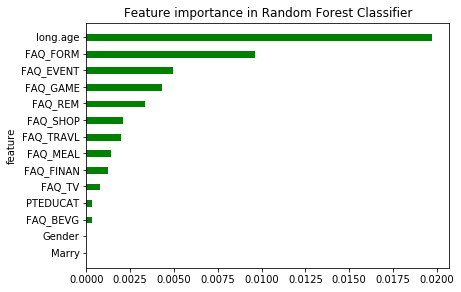

<Figure size 360x360 with 0 Axes>

In [89]:
fig, ax = plt.subplots() 
width = 0.4
ind = np.arange(len(scores))
ax.barh(ind, scores[::-1], width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(ticks[::-1], minor=False)
plt.title("Feature importance in Random Forest Classifier")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

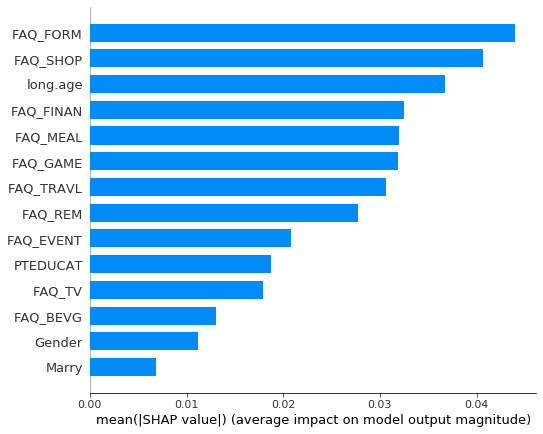

In [90]:
shap_values = shap.TreeExplainer(clf_total.best_estimator_).shap_values(x_total)
shap.summary_plot(shap_values[0], x_total,feature_names = feature_names_total,plot_type = "bar")

### Gradient Boosting

In [91]:
gbf_total = GridSearchCV(estimator = GB, param_grid = gb_grid,
                   cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
gbf_total_fit = gbf_total.fit(x_total,y)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  1.9min finished


In [92]:
gb_feature_importances_total = permutation_importance(gbf_total_fit, x_total, y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [93]:
feature_names_total = ["FAQ_FINAN","FAQ_FORM","FAQ_SHOP",
                                        "FAQ_GAME","FAQ_BEVG","FAQ_MEAL","FAQ_EVENT","FAQ_TV","FAQ_REM"
                         ,"FAQ_TRAVL","PTEDUCAT","Gender","Marry","long.age"]
gb_indices_total = np.argsort(gb_feature_importances_total.importances_mean)[::-1]
scores = []
ticks = []
for i in gb_indices_total:
    scores.append(gb_feature_importances_total.importances_mean[i])
    ticks.append(feature_names_total[i])
    print("{}: {:.3f}".format(feature_names_total[i], gb_feature_importances_total.importances_mean[i]))

long.age: 0.125
FAQ_GAME: 0.028
FAQ_MEAL: 0.021
FAQ_EVENT: 0.018
FAQ_FORM: 0.013
FAQ_BEVG: 0.010
FAQ_SHOP: 0.008
FAQ_TRAVL: 0.007
FAQ_FINAN: 0.006
FAQ_TV: 0.005
PTEDUCAT: 0.001
Marry: 0.001
FAQ_REM: 0.000
Gender: 0.000


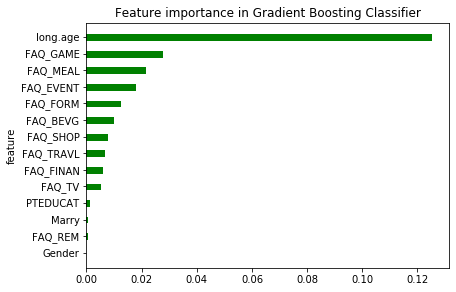

<Figure size 360x360 with 0 Axes>

In [94]:
fig, ax = plt.subplots() 
width = 0.4
ind = np.arange(len(scores))
ax.barh(ind, scores[::-1], width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(ticks[::-1], minor=False)
plt.title("Feature importance in Gradient Boosting Classifier")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

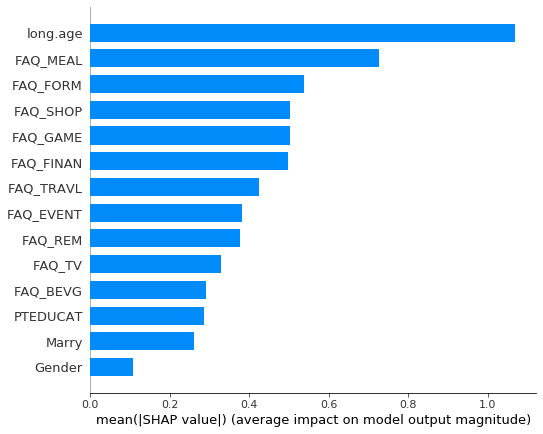

In [95]:
gb_shap_values = shap.TreeExplainer(gbf_total.best_estimator_).shap_values(x_total)
shap.summary_plot(gb_shap_values, x_total,feature_names = feature_names_total,plot_type = "bar")

### Logistic Regression

In [96]:
lr_grid_2 = {"penalty":["l1","l2"],
          "C":np.logspace(-4,4,20),
          "solver":['newton-cg', 'lbfgs','sag', 'saga'],
          "max_iter":[8000,10000]}
lrf_total = GridSearchCV(estimator = LR, param_grid = lr_grid_2,
                   cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
lrf_total_fit = lrf_total.fit(x_total,y)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:   10.0s finished


In [97]:
lr_feature_importances_total = permutation_importance(lrf_total_fit, x_total,
                                                      y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [98]:
feature_names_total = ["FAQ_FINAN","FAQ_FORM","FAQ_SHOP",
                                        "FAQ_GAME","FAQ_BEVG","FAQ_MEAL","FAQ_EVENT","FAQ_TV","FAQ_REM"
                         ,"FAQ_TRAVL","PTEDUCAT","Gender","Marry","long.age"]
lr_indices_total = np.argsort(lr_feature_importances_total.importances_mean)[::-1]
scores = []
ticks = []
for i in lr_indices_total:
    scores.append(lr_feature_importances_total.importances_mean[i])
    ticks.append(feature_names_total[i])
    print("{}: {:.3f}".format(feature_names_total[i], lr_feature_importances_total.importances_mean[i]))

FAQ_SHOP: 0.023
FAQ_FORM: 0.021
FAQ_MEAL: 0.014
FAQ_REM: 0.014
FAQ_GAME: 0.011
FAQ_EVENT: 0.007
FAQ_TV: 0.006
FAQ_TRAVL: 0.002
Marry: 0.002
FAQ_FINAN: 0.001
Gender: 0.000
PTEDUCAT: 0.000
long.age: 0.000
FAQ_BEVG: -0.000


## Nested Cross Validation

In [70]:
rf_class_probabilities_total = cross_val_predict(estimator = clf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 12.4min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 20.3min finished


In [71]:
gb_class_probabilities_total = cross_val_predict(estimator = gbf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 17.8min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 30.9min finished


In [72]:
lr_class_probabilities_total = cross_val_predict(estimator = lrf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.4min remaining:   55.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


In [73]:
rf_proba_total = rf_class_probabilities_total[:,1]

rf_fraction_of_positives_total, rf_mean_predicted_value_total = calibration_curve(y, rf_proba_total, n_bins=10)

In [74]:
gb_proba_total = gb_class_probabilities_total[:,1]

gb_fraction_of_positives_total, gb_mean_predicted_value_total = calibration_curve(y, gb_proba_total, n_bins=10)

In [75]:
lr_proba_total = lr_class_probabilities_total[:,1]

lr_fraction_of_positives_total, lr_mean_predicted_value_total = calibration_curve(y, lr_proba_total, n_bins=10)

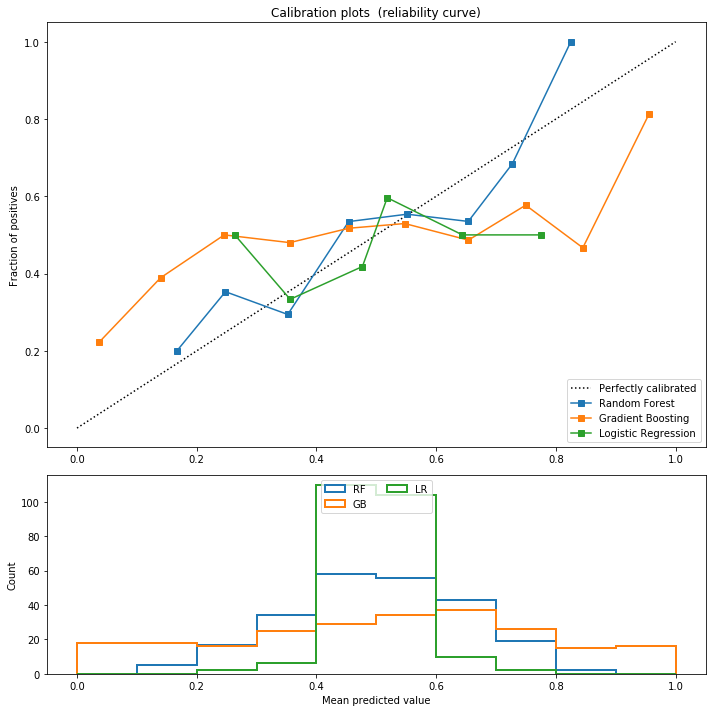

In [76]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(rf_mean_predicted_value_total, rf_fraction_of_positives_total, "s-",
             label="%s" % ("Random Forest", ))
ax1.plot(gb_mean_predicted_value_total, gb_fraction_of_positives_total, "s-",
             label="%s" % ("Gradient Boosting", ))
ax1.plot(lr_mean_predicted_value_total, lr_fraction_of_positives_total, "s-",
             label="%s" % ("Logistic Regression", ))


ax2.hist(rf_proba_total, range=(0, 1), bins=10, label="RF",
             histtype="step", lw=2)
ax2.hist(gb_proba_total, range=(0, 1), bins=10, label="GB",
             histtype="step", lw=2)
ax2.hist(lr_proba_total, range=(0, 1), bins=10, label="LR",
             histtype="step", lw=2)
    
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [79]:
rf_nested_scores_total = cross_validate(estimator = clf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 12.8min remaining:  8.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 20.6min finished


In [80]:
gb_nested_scores_total = cross_validate(estimator = gbf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 17.8min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 30.9min finished


In [81]:
lr_nested_scores_total = cross_validate(estimator = lrf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.4min remaining:   55.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


In [82]:
print("Accuracy:", statistics.mean(rf_nested_scores_total['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(rf_nested_scores_total['test_balanced_acc']))
print("Precision:", statistics.mean(rf_nested_scores_total['test_precision']))
print("Specificity:", statistics.mean(rf_nested_scores_total['test_specificity']))
print("Sensitivity:", statistics.mean(rf_nested_scores_total['test_sensitivity']))
print("Matthews Correlation Coefficient:", statistics.mean(rf_nested_scores_total['test_MCC']))
print("F1 Score:", statistics.mean(rf_nested_scores_total['test_f1_score']))
print("ROC:", statistics.mean(rf_nested_scores_total['test_roc']))

Accuracy: 0.576268115942029
Balanced Accuracy: 0.5772727272727273
Precision: 0.5832442067736185
Specificity: 0.5636363636363636
Sensitivity: 0.5909090909090909
Matthews Correlation Coefficient: 0.1613682511397033
F1 Score: 0.5772519509476031
ROC: 0.6304924242424242


In [83]:
print("Accuracy:", statistics.mean(gb_nested_scores_total['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(gb_nested_scores_total['test_balanced_acc']))
print("Precision:", statistics.mean(gb_nested_scores_total['test_precision']))
print("Specificity:", statistics.mean(gb_nested_scores_total['test_specificity']))
print("Sensitivity:", statistics.mean(gb_nested_scores_total['test_sensitivity']))
print("Matthews Correlation Coefficient:", statistics.mean(gb_nested_scores_total['test_MCC']))
print("F1 Score:", statistics.mean(gb_nested_scores_total['test_f1_score']))
print("ROC:", statistics.mean(gb_nested_scores_total['test_roc']))

Accuracy: 0.5597826086956522
Balanced Accuracy: 0.559469696969697
Precision: 0.5540433177933177
Specificity: 0.5121212121212121
Sensitivity: 0.6068181818181818
Matthews Correlation Coefficient: 0.12528114225200146
F1 Score: 0.5715495724717693
ROC: 0.6198232323232323


In [84]:
print("Accuracy:", statistics.mean(lr_nested_scores_total['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(lr_nested_scores_total['test_balanced_acc']))
print("Precision:", statistics.mean(lr_nested_scores_total['test_precision']))
print("Specificity:", statistics.mean(lr_nested_scores_total['test_specificity']))
print("Sensitivity:", statistics.mean(lr_nested_scores_total['test_sensitivity']))
print("Matthews Correlation Coefficient:", statistics.mean(lr_nested_scores_total['test_MCC']))
print("F1 Score:", statistics.mean(lr_nested_scores_total['test_f1_score']))
print("ROC:", statistics.mean(lr_nested_scores_total['test_roc']))

Accuracy: 0.5809782608695653
Balanced Accuracy: 0.5814393939393939
Precision: 0.6072588522588522
Specificity: 0.581060606060606
Sensitivity: 0.5818181818181818
Matthews Correlation Coefficient: 0.1774993638347594
F1 Score: 0.5713830840013802
ROC: 0.6578282828282829


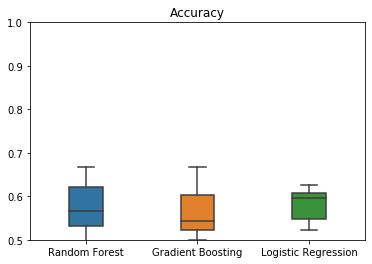

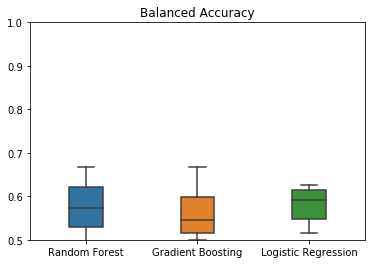

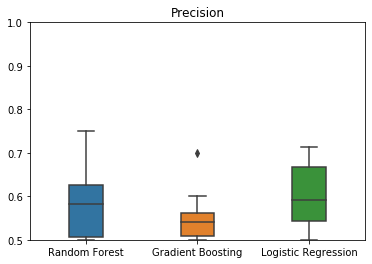

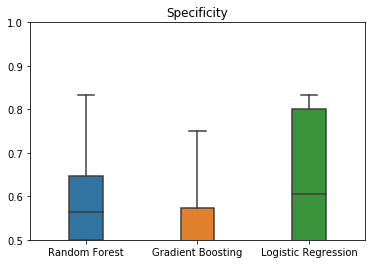

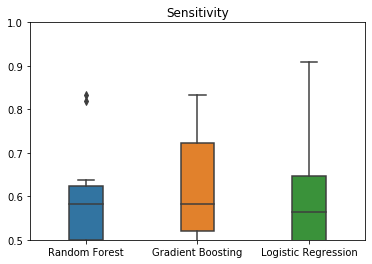

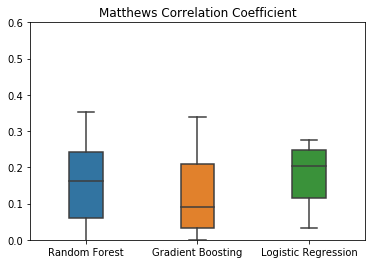

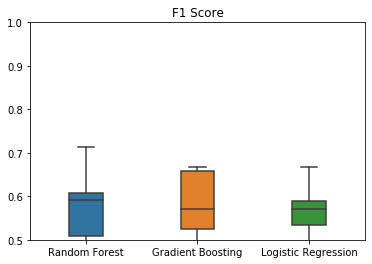

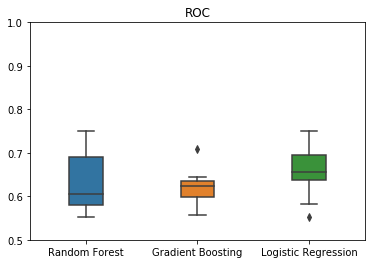

In [85]:
rf_acc = rf_nested_scores_total['test_accuracy']
gb_acc = gb_nested_scores_total['test_accuracy']
lr_acc = lr_nested_scores_total['test_accuracy']
sns.boxplot(data = [rf_acc,gb_acc,lr_acc], width = 0.3).set_title("Accuracy")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_ba_acc = rf_nested_scores_total['test_balanced_acc']
gb_ba_acc = gb_nested_scores_total['test_balanced_acc']
lr_ba_acc = lr_nested_scores_total['test_balanced_acc']
sns.boxplot(data = [rf_ba_acc,gb_ba_acc,lr_ba_acc], width = 0.3).set_title("Balanced Accuracy")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_precision = rf_nested_scores_total['test_precision']
gb_precision = gb_nested_scores_total['test_precision']
lr_precision = lr_nested_scores_total['test_precision']
sns.boxplot(data = [rf_precision,gb_precision,lr_precision], width = 0.3).set_title("Precision")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_spec = rf_nested_scores_total['test_specificity']
gb_spec = gb_nested_scores_total['test_specificity']
lr_spec = lr_nested_scores_total['test_specificity']
sns.boxplot(data = [rf_spec,gb_spec,lr_spec], width = 0.3).set_title("Specificity")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_sens = rf_nested_scores_total['test_sensitivity']
gb_sens = gb_nested_scores_total['test_sensitivity']
lr_sens = lr_nested_scores_total['test_sensitivity']
sns.boxplot(data = [rf_sens,gb_sens,lr_sens], width = 0.3).set_title("Sensitivity")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_mcc = rf_nested_scores_total['test_MCC']
gb_mcc = gb_nested_scores_total['test_MCC']
lr_mcc = lr_nested_scores_total['test_MCC']
sns.boxplot(data = [rf_mcc,gb_mcc,lr_mcc], width = 0.3).set_title("Matthews Correlation Coefficient")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0,0.6)
plt.show()

rf_f1 = rf_nested_scores_total['test_f1_score']
gb_f1 = gb_nested_scores_total['test_f1_score']
lr_f1 = lr_nested_scores_total['test_f1_score']
sns.boxplot(data = [rf_f1,gb_f1,lr_f1], width = 0.3).set_title("F1 Score")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_roc = rf_nested_scores_total['test_roc']
gb_roc = gb_nested_scores_total['test_roc']
lr_roc = lr_nested_scores_total['test_roc']
sns.boxplot(data = [rf_roc,gb_roc,lr_roc], width = 0.3).set_title("ROC")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

In [99]:
feat_names = jadni_data.filter(items = ["FAQ_FINAN","FAQ_FORM","FAQ_SHOP",
                                        "FAQ_GAME","FAQ_BEVG","FAQ_MEAL","FAQ_EVENT","FAQ_TV","FAQ_REM"
                         ,"FAQ_TRAVL"]).columns
mci = jadni_data.loc[jadni_data['DXCURREN'] == "MCI"]
ad = jadni_data.loc[jadni_data['DXCURREN'] == "AD"]
for i in feat_names:
    print(i)
    stat, p = wilcoxon(mci[i], ad[i])
    print('Statistics=%.3f, p=%.20f' % (stat, p))

FAQ_FINAN
Statistics=384.500, p=0.00000761916741863601
FAQ_FORM
Statistics=323.000, p=0.00000075467925058562
FAQ_SHOP
Statistics=204.500, p=0.00000250170077251202
FAQ_GAME
Statistics=276.000, p=0.00040265006368152848
FAQ_BEVG
Statistics=52.500, p=0.00486181544532682686
FAQ_MEAL
Statistics=344.500, p=0.00002233641365778945
FAQ_EVENT
Statistics=415.500, p=0.01743688744165415236
FAQ_TV
Statistics=329.500, p=0.07633681425042962432
FAQ_REM
Statistics=329.000, p=0.00029101422851580613
FAQ_TRAVL
Statistics=270.000, p=0.00006964936181970442


In [103]:
feat_names = jadni_data.filter(items = ["FAQ_FINAN","FAQ_FORM","FAQ_SHOP",
                                        "FAQ_GAME","FAQ_BEVG","FAQ_MEAL","FAQ_EVENT","FAQ_TV","FAQ_REM"
                         ,"FAQ_TRAVL"]).columns
mci = jadni_data.loc[jadni_data['DXCURREN'] == "MCI"]
ad = jadni_data.loc[jadni_data['DXCURREN'] == "AD"]
p_vals = []
for i in feat_names:
    stat, p = wilcoxon(mci[i], ad[i])
    p_vals.append(p)
    
p_val_corrected = multitest.multipletests(p_vals, method='fdr_bh')
p_val_corrected[1]

for i in range(0,len(feat_names)):
    print(feat_names[i], p_val_corrected[1][i])

FAQ_FINAN 2.539722472878669e-05
FAQ_FORM 7.546792505856163e-06
FAQ_SHOP 1.2508503862560085e-05
FAQ_GAME 0.0005752143766878979
FAQ_BEVG 0.006077269306658533
FAQ_MEAL 5.584103414447363e-05
FAQ_EVENT 0.019374319379615725
FAQ_TV 0.07633681425042962
FAQ_REM 0.00048502371419301024
FAQ_TRAVL 0.00013929872363940883
